## 数据归一化
清除一些用来展示的代码，清空之前的运行结果

### 数据读取与展示

In [1]:
# 使用tf.keras搭建分类模型
#导入必要的库即版本

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
#import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd,sklearn,tf,keras:
    print(module.__name__, module.__version__)

2.0.0-beta1
sys.version_info(major=3, minor=7, micro=0, releaselevel='final', serial=0)
matplotlib 2.2.3
numpy 1.16.4
pandas 0.23.4
sklearn 0.19.2
tensorflow 2.0.0-beta1
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
#导入数据集并拆分数据集
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_train.shape, y_valid.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(55000, 28, 28) (5000,)
(5000, 28, 28) (5000,)
(10000, 28, 28) (10000,)


In [3]:
print(np.max(x_train), np.min(x_train))

255 0


### 增加代码归一化

In [4]:
# 归一化方法：x = (x - u) / std 均值，方差

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train:[None, 28, 28] -> [None, 784]
# 除了transform功能还有fit的功能（记住训练集的均值方差），验证集和测试集需要使用训练集的均值和方差
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

In [5]:
print(np.max(x_train_scaled), np.min(x_train_scaled))

2.023144 -0.81051385


### 模型构建
不同版本API，代码不尽相同

In [6]:
# 使用tf.keras.model.Sequential()构建模型

# 创建Sequential对象
model = keras.models.Sequential()
# 添加输入层,将输入图片展平，将28X28的矩阵展开为一维向量
model.add(keras.layers.Flatten(input_shape=[28, 28]))
# 添加全连接层，神经元设为300，激活函数为‘relu’
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
# 添加输出，长度为10的向量，激活函数为'softmax'
model.add(keras.layers.Dense(10, activation='softmax'))

# 另外一种写法
#model = keras.models.Sequential([
#    keras.layers.Flatten(input_shape=[28,28]),
#    keras.layers.Dense(300, activation='relu'),
#    keras.layers.Dense(100, activation='relu'),
#    keras.layers.Dense(10, activation='softmax')
#])

# relu: y=max(0,x)
# softmax: 将向量变成概率分布，x = [x1, x2, x3],三个数加起来为1
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum=e^x1+e^x2+e^x3

# 计算目标函数
# 损失函数使用'sparse_categorical_crossentropy'，即交叉熵，categorical类别
# reason for sparse: y_valid是长度等于样本数目的一个向量，y只是一个index值使用'sparse_categorical_crossentropy'
# y->one hot->[]将y转换为向量使用'categorical_crossentropy'
# 2.0版本可以直接使用optimizer='sgd',学习率的默认值不同
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='sgd', metrics=['accuracy'])

In [7]:
# 开启训练fit函数
# epochs训练次数，history返回为中间运算的一些结果
history = model.fit(x_train_scaled, y_train, epochs=10,
         validation_data=(x_valid_scaled,y_valid))

W0716 22:56:36.870329  8796 deprecation.py:323] From D:\SoftWare\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 3s 63us/sample - loss: 0.5308 - accuracy: 0.8107 - val_loss: 0.4050 - val_accuracy: 0.8590
Epoch 2/10
55000/55000 [==============================] - 3s 63us/sample - loss: 0.3876 - accuracy: 0.8605 - val_loss: 0.3788 - val_accuracy: 0.8634
Epoch 3/10
55000/55000 [==============================] - 3s 58us/sample - loss: 0.3513 - accuracy: 0.8727 - val_loss: 0.3467 - val_accuracy: 0.8788
Epoch 4/10
55000/55000 [==============================] - 4s 66us/sample - loss: 0.3267 - accuracy: 0.8808 - val_loss: 0.3429 - val_accuracy: 0.8744
Epoch 5/10
55000/55000 [==============================] - 4s 67us/sample - loss: 0.3077 - accuracy: 0.8890 - val_loss: 0.3294 - val_accuracy: 0.8810
Epoch 6/10
55000/55000 [==============================] - 4s 72us/sample - loss: 0.2908 - accuracy: 0.8940 - val_loss: 0.3131 - val_accuracy: 0.8892
Epoch 7/10
55000/55000 [==============================] -

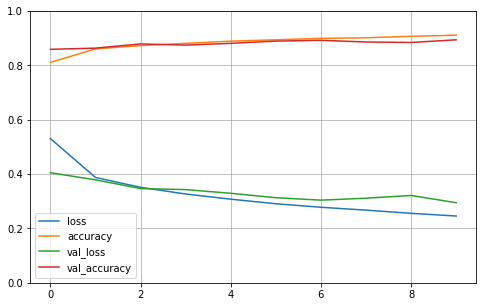

In [8]:
# 将history中的值可视化出来
def plot_learning_curves(history):
    #直接转换为DataFrame
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    # 显示网格
    plt.grid(True)
    # 设置坐标轴范围
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curves(history)

In [9]:
model.evaluate(x_test_scaled, y_test)

10000/10000 [==============================] - 0s 32us/sample - loss: 0.3277 - accuracy: 0.8826


[0.3277453017234802, 0.8826]